In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
import anndata
import scanpy as sc

from os.path import join

# Read data

In [2]:
PATH = '/lustre/scratch/users/felix.fischer/merlin_cxg_simple_norm_parquet'

In [3]:
ddf = dd.read_parquet(join(PATH, 'train'))
cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))

In [4]:
def get_count_matrix_and_obs(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19357)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[['cell_type', 'tech_sample', 'assay_sc', 'id', 'organ']].compute()

    return x, obs

In [5]:
x, obs = get_count_matrix_and_obs(ddf)

In [6]:
x

dask.array<values, shape=(6631424, 19357), dtype=float32, chunksize=(1024, 19357), chunktype=numpy.ndarray>

In [7]:
obs

,cell_type,tech_sample,assay_sc,id,organ
0,2,219,3,8,5
1,7,1553,2,104,0
2,2,191,3,8,5
3,18,578,2,27,80
4,104,1376,2,87,6
...,...,...,...,...,...
1019,64,387,0,15,63
1020,64,75,2,3,24
1021,0,1287,0,84,5
1022,18,578,2,27,80


In [8]:
n_samples = 1_000_000

x_sample = x[:n_samples]
obs_sample = obs[:n_samples]

# Compute PCA + TSNE

In [ ]:
from dask_ml.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=50, iterated_power=4)
x_pca, var_explained_ratio = da.compute([pca.fit_transform(x), pca.explained_variance_ratio_])[0]

/home/icb/felix.fischer/Programs/anaconda3/envs/dask/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
adata = anndata.AnnData(X=x_pca[:n_samples].astype('f4'), obs=obs_sample)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)

/home/icb/felix.fischer/Programs/anaconda3/envs/dask/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/felix.fischer/Programs/anaconda3/envs/dask/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
adata.write('vis.h5ad')

# Compute data augmentation

In [115]:
max_augmentations = 500

In [116]:
x_dense = x_sample.compute()
tech_samples = obs_sample.tech_sample.to_numpy()
cell_types = obs_sample.cell_type.to_numpy()

In [117]:
from typing import List

from numba import njit, prange


@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

@njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)


@njit(parallel=True)
def calculate_means(x_gene: np.ndarray, tech_sample: np.ndarray, cell_type: np.ndarray):
    n_cell_type = np.max(cell_type) + 1
    means_grouped_by_cell_type = [
        np.zeros((len(np.unique(tech_sample[cell_type == i])), x_gene.shape[1]), dtype='f4')
        for i in range(n_cell_type)
    ]

    for i in prange(n_cell_type):
        for ix_sample, sample in enumerate(np.unique(tech_sample[cell_type == i])):
            means_grouped_by_cell_type[i][ix_sample, :] = np_mean(x_gene[(cell_type == i) & (tech_sample == sample), :], axis=0)

    return means_grouped_by_cell_type


@njit
def get_combinations(n, max_combinations):
    n_combinations = (n * (n - 1)) // 2 - 1
    if max_combinations < 0:
        max_combinations = n_combinations
    combinations = []

    for i in range(n):
        for j in range(i+1, n):
            combinations.append([i, j])

    combinations = np.array(combinations)
    idx_sample = np.random.choice(combinations.shape[0], min([n_combinations, max_combinations]), replace=False)

    return combinations[idx_sample, :]


def calculate_data_augmentation(mean_vecs: List[np.ndarray], max_augmentations: int = 50):
    n_means = [mean_vec.shape[0] for mean_vec in mean_vecs]
    n_genes = mean_vecs[0].shape[1]

    data_augmentation = [np.zeros((min([(n * (n - 1)) // 2 - 1, max_augmentations]), n_genes)) for n in n_means]

    for i in prange(len(n_means)):
        means = mean_vecs[i]
        for ix, (j, k) in enumerate(get_combinations(n_means[i], max_augmentations)):
            data_augmentation[i][ix, :] = means[j, :] - means[k, :]

    return data_augmentation



In [118]:
x_dense.dtype

dtype('float32')

In [119]:
mean_vectors = calculate_means(x_dense, tech_samples, cell_types)

In [120]:
mean_vectors[10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18279275, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.43643808, 0.        , 0.4320459 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [121]:
augmentations = calculate_data_augmentation(mean_vectors, max_augmentations)

In [122]:
augmentations[0]

array([[ 0.        ,  0.        , -0.00367935, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.0412865 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.06247641, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.07280071, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.05591063, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02267554, ...,  0.        ,
         0.        ,  0.        ]])

In [123]:
augmentations_concat = np.concatenate(augmentations, axis=0)

# Select data augmentations to use

In [126]:
import anndata
import scanpy as sc

augmentations_adata = anndata.AnnData(X=augmentations_concat)
augmentations_adata.obs['cell_type'] = (
    cell_type_mapping
    .loc[np.repeat(range(len(cell_type_mapping)), [augment.shape[0] for augment in augmentations])]
    .to_numpy()
)

/tmp/ipykernel_46138/3370251908.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  augmentations_adata = anndata.AnnData(X=augmentations_concat)


In [127]:
sc.pp.pca(augmentations_adata)

/home/icb/felix.fischer/Programs/anaconda3/envs/dask/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [147]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=50, n_init='auto').fit(augmentations_concat)
augmentations_adata.obs['kmeans_cluster'] = kmeans.labels_
augmentations_adata.obs['kmeans_cluster'] = augmentations_adata.obs['kmeans_cluster'].astype('category')

/home/icb/felix.fischer/Programs/anaconda3/envs/dask/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


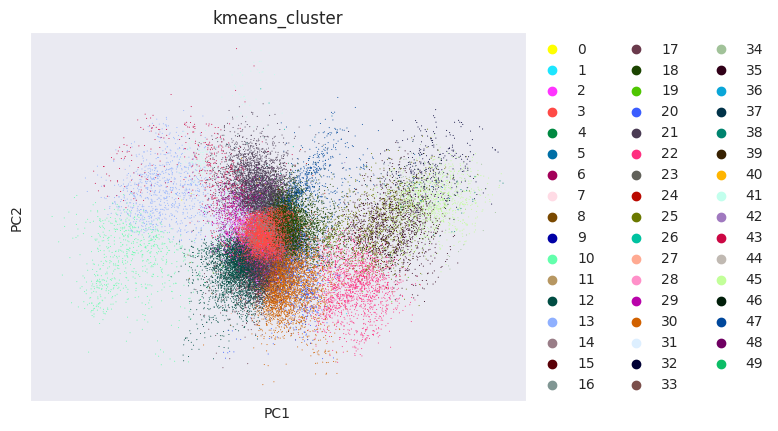

In [148]:
sc.pl.pca(augmentations_adata, color='kmeans_cluster')

In [150]:
pd.Series(kmeans.labels_).value_counts().to_dict()

{3: 13792,
 18: 5452,
 12: 4388,
 16: 4346,
 17: 4314,
 21: 4094,
 30: 3494,
 31: 2849,
 2: 2391,
 22: 1631,
 35: 1213,
 45: 1060,
 25: 1018,
 20: 907,
 13: 888,
 10: 691,
 43: 670,
 47: 633,
 29: 627,
 32: 356,
 41: 262,
 34: 224,
 4: 38,
 38: 32,
 33: 26,
 14: 25,
 6: 25,
 5: 25,
 37: 24,
 46: 22,
 24: 22,
 9: 22,
 23: 20,
 39: 20,
 15: 19,
 40: 19,
 44: 18,
 36: 17,
 26: 16,
 19: 15,
 11: 14,
 8: 14,
 48: 13,
 28: 10,
 27: 9,
 49: 9,
 42: 8,
 7: 6,
 0: 4,
 1: 4}

In [158]:
SAMPLE_SIZE = 7500


rng = np.random.default_rng(seed=1)
sampling_probs = 1. / pd.Series(kmeans.labels_).replace(pd.Series(kmeans.labels_).value_counts().to_dict())
sampling_probs = sampling_probs / sampling_probs.sum()
idx_subsample = rng.choice(np.arange(augmentations_concat.shape[0]), size=SAMPLE_SIZE, replace=False, p=sampling_probs)


with open('augmentations.npy', 'wb') as f:
    np.save(f, augmentations_concat[idx_subsample, :])


# Check out augmentations

In [160]:
print(f'size augmentation file: {augmentations_concat[idx_subsample, :].size * 8 // 1000**2} MB')

size augmentation file: 1161 MB


In [161]:
(augmentations_concat[idx_subsample, :] > 0.).mean()

0.22847453634344164

In [193]:
(x_dense > 0.).mean()

0.09444242098465672

In [162]:
augmentations_concat[idx_subsample, :].shape

(7500, 19357)